this is a first try to write an uber system myself and see what happens

In [1]:
class uber_client:
    '''
    A client in the uber simulation 
    '''
    def __init__(self,arrival_time, current_location, destination, behavour_type= "Normal"):
        ''' 
        Initialize a uber client.

        args:
        todo
        '''
        # basic attributes 
        self.arrival_time = arrival_time
        self.current_location = current_location
        self.destination = destination
        self.behavour_type = behavour_type   


class uber_driver:
    def __init__(self, current_location, behavour_type= "Normal", status = "Idle"):
        '''
        Initialize a uber driver

        args:
        todo
        '''
        # basic attributes
        self.current_location = current_location
        self.behavour_type = behavour_type
        self.status = status

        # calculated attributes
        self.service_time = 0
        self.waiting_time = 0

class uber_network:
    def __init__(self, city_map, traffic_generator):
        '''
        Initialize the uber network

        args:
        todo
        '''
        self.city_map = city_map
        self.traffic_generator = traffic_generator

class city_map:
    def __init__(self, grid_size, road_network):
        pass

class traffic_generator:
    def __init__(self, city_map, hotspots):
        pass

In [2]:
from dataclasses import dataclass
from enum import Enum
import random
from collections import defaultdict
from typing import Any, Dict, Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
import queue

@dataclass
class Location:
    x:int
    y:int


# New Event System
class EventType(Enum):
    CLIENT_ARRIVAL = "CLIENT_ARRIVAL"
    DRIVER_ARRIVAL = "DRIVER_ARRIVAL"
    DRIVER_PICKUP_START = "DRIVER_PICKUP_START"
    DRIVER_PICKUP_END = "DRIVER_PICKUP_END"
    RIDE_START = "RIDE_START"
    RIDE_END = "RIDE_END"
    CLIENT_CANCELLATION = "CLIENT_CANCELLATION"
    DRIVER_SHIFT_END = "DRIVER_SHIFT_END"

@dataclass
class EventInfo:
    """Lightweight class to store essential event information"""
    client_id: Optional[str] = None
    driver_id: Optional[str] = None
    start_location: Optional[Tuple[int, int]] = None
    end_location: Optional[Tuple[int, int]] = None
    cancelled: bool = False

@dataclass
class Event:
    time: float
    event_type: EventType
    info: EventInfo
    
    def __lt__(self, other):
        return self.time < other.time

class FutureEventSet:
    def __init__(self):
        self.events = queue.PriorityQueue()
        self.current_time = 0.0
        
        # Reference dictionaries to store full objects
        self.client_registry: Dict[str, 'uber_client'] = {}
        self.driver_registry: Dict[str, 'uber_driver'] = {}
        
        # Keep track of pending events for cancellation
        self.pending_events: Dict[str, list[Event]] = {}
    
    def is_empty(self) -> bool:
        """Check if event queue is empty"""
        return self.events.empty()

    def register_client(self, client: 'uber_client') -> str:
        """Register a client using their assigned ID"""
        self.client_registry[client.client_id] = client
        self.pending_events[client.client_id] = []
        return client.client_id
    
    def register_driver(self, driver: 'uber_driver') -> str:
        """Register a driver using their assigned ID"""
        self.driver_registry[driver.driver_id] = driver
        self.pending_events[driver.driver_id] = []
        return driver.driver_id
    
    def cleanup_registry(self, entity_id: str):
        """Clean up registry entries and pending events"""
        # Remove from registries
        self.client_registry.pop(entity_id, None)
        self.driver_registry.pop(entity_id, None)
        
        # Clean up pending events
        self.pending_events.pop(entity_id, None)
    
    def validate_event_time(self, time: float) -> float:
        """Validate and adjust event time if necessary"""
        if time < self.current_time:
            return self.current_time
        return time

    def add_event(self, event: Event):
        """Add a new event to the priority queue and track it"""
        # Validate time
        event.time = self.validate_event_time(event.time)
        
        # Add to queue
        self.events.put(event)
        
        # Initialize pending_events lists if they don't exist
        if event.info.client_id and event.info.client_id not in self.pending_events:
            self.pending_events[event.info.client_id] = []
            
        if event.info.driver_id and event.info.driver_id not in self.pending_events:
            self.pending_events[event.info.driver_id] = []
        
        # Track event for entities involved
        if event.info.client_id:
            self.pending_events[event.info.client_id].append(event)
        if event.info.driver_id:
            self.pending_events[event.info.driver_id].append(event)
    
    def cancel_entity_events(self, entity_id: str):
        """Cancel all pending events for a client or driver"""
        if entity_id in self.pending_events:
            for event in self.pending_events[entity_id]:
                event.info.cancelled = True
            self.pending_events[entity_id].clear()
    
    def get_next_event(self) -> Tuple[Optional[Event], Optional['uber_client'], Optional['uber_driver']]:
        """Get next valid event and associated objects"""
        while not self.events.empty():
            event = self.events.get()
            
            # Skip cancelled events
            if event.info.cancelled:
                continue
                
            self.current_time = event.time
            
            # Get associated objects
            client = self.get_client(event.info.client_id) if event.info.client_id else None
            driver = self.get_driver(event.info.driver_id) if event.info.driver_id else None
            
            return event, client, driver
            
        return None, None, None

    def get_client(self, client_id: str) -> Optional['uber_client']:
        """Retrieve client object from registry"""
        return self.client_registry.get(client_id)
    
    def get_driver(self, driver_id: str) -> Optional['uber_driver']:
        """Retrieve driver object from registry"""
        return self.driver_registry.get(driver_id)

    # Event scheduling methods
    def schedule_client_arrival(self, time: float, client: 'uber_client'):
        """Schedule client arrival with registration check"""
        if client.client_id not in self.client_registry:
            self.register_client(client)
            
        event = Event(
            time=time,
            event_type=EventType.CLIENT_ARRIVAL,
            info=EventInfo(
                client_id=client.client_id,
                start_location=(client.current_location.x, client.current_location.y)
            )
        )
        self.add_event(event)
    
    def schedule_driver_arrival(self, time: float, driver: 'uber_driver'):
        """Schedule driver arrival with registration check"""
        if driver.driver_id not in self.driver_registry:
            self.register_driver(driver)
            
        event = Event(
            time=time,
            event_type=EventType.DRIVER_ARRIVAL,
            info=EventInfo(
                driver_id=driver.driver_id,
                start_location=(driver.current_location.x, driver.current_location.y)
            )
        )
        self.add_event(event)

    
    def schedule_pickup_start(self, time: float, client: 'uber_client', driver: 'uber_driver'):
        """Schedule pickup start with registration checks"""
        if client.client_id not in self.client_registry:
            self.register_client(client)
        if driver.driver_id not in self.driver_registry:
            self.register_driver(driver)
            
        event = Event(
            time=time,
            event_type=EventType.DRIVER_PICKUP_START,
            info=EventInfo(
                client_id=client.client_id,
                driver_id=driver.driver_id,
                start_location=(driver.current_location.x, driver.current_location.y),
                end_location=(client.current_location.x, client.current_location.y)
            )
        )
        self.add_event(event)


    def schedule_pickup_end(self, time: float, client: 'uber_client', driver: 'uber_driver'):
        event = Event(
            time=time,
            event_type=EventType.DRIVER_PICKUP_END,
            info=EventInfo(
                client_id=str(id(client)),
                driver_id=str(id(driver)),
                start_location=(driver.current_location.x, driver.current_location.y),
                end_location=(client.current_location.x, client.current_location.y)
            )
        )
        self.add_event(event)

    def schedule_pickup_start(self, time: float, client: 'uber_client', driver: 'uber_driver'):
        event = Event(
            time=time,
            event_type=EventType.DRIVER_PICKUP_START,
            info=EventInfo(
                client_id=client.client_id,
                driver_id=driver.driver_id,
                start_location=(driver.current_location.x, driver.current_location.y),
                end_location=(client.current_location.x, client.current_location.y)
            )
        )
        self.add_event(event)

    def schedule_ride_start(self, time: float, client: 'uber_client', driver: 'uber_driver'):
        event = Event(
            time=time,
            event_type=EventType.RIDE_START,
            info=EventInfo(
                client_id=client.client_id,
                driver_id=driver.driver_id,
                start_location=(client.current_location.x, client.current_location.y),
                end_location=(client.destination.x, client.destination.y)
            )
        )
        self.add_event(event)

    def schedule_client_cancellation(self, time: float, client: 'uber_client'):
        event = Event(
            time=time,
            event_type=EventType.CLIENT_CANCELLATION,
            info=EventInfo(client_id=str(id(client)))
        )
        self.add_event(event)

    def schedule_driver_shift_end(self, time: float, driver: 'uber_driver'):
        """Schedule driver shift end with proper registration check"""
        # Ensure driver is registered first
        if driver.driver_id not in self.driver_registry:
            self.register_driver(driver)
            
        event = Event(
            time=time,
            event_type=EventType.DRIVER_SHIFT_END,
            info=EventInfo(driver_id=driver.driver_id)  # Use driver.driver_id instead of str(id(driver))
        )
        self.add_event(event)

    
    def get_registry_state(self):
        """Get current state of registries for debugging"""
        return {
            'clients': list(self.client_registry.keys()),
            'drivers': list(self.driver_registry.keys()),
            'pending_events': {k: len(v) for k, v in self.pending_events.items()}
        }

class uber_client:
    '''
    A client in the uber simulation 
    '''
    _next_id = 1

    def __init__(self,arrival_time, current_location:Location, destination:Location, 
                 behavour_type= "Normal",max_wait_time:float = 15.0
                 ):
        ''' 
        Initialize a uber client(rider).

        args:
        todo
        '''

        self.client_id = f"C{uber_client._next_id}"
        uber_client._next_id += 1
        # basic attributes 
        self.arrival_time = arrival_time
        self.current_location = current_location
        self.destination = destination
        self.behavour_type = behavour_type  
        self.max_wait_time = max_wait_time

        #status tracking
        self.status = "Waiting" # Waiting, Matched, InRide, Completed, Cancelled
        self.assigned_driver = None
        self.pickup_time = None
        self.completion_time = None

        # statistics
        self.waiting_time = 0
        self.ride_time = 0
        self.total_cost = 0

    @classmethod
    def generate_client(cls,city_map,current_time, behavior_dist = None):
        '''
        Generate a new client

        args:
            city_map
            arrival_time
            behavior_dist
        '''

        if behavior_dist == None:
            behavior_dist = {
                "Normal":0.7,
                "Premium":0.2,
                "Patient":0.1
            }
        
        grid_size = (city_map.width, city_map.height)
        start_loc = Location(
            x = random.randint(0,grid_size[0]-1),
            y = random.randint(0,grid_size[1]-1)
        )
        # ensure they are not the same pos
        while True:
            des_loc = Location(
            x = random.randint(0,grid_size[0]-1),
            y = random.randint(0,grid_size[1]-1)
        )
            if (des_loc.x != start_loc.x) or (des_loc.y != start_loc.y):
                break
        behavior = random.choices(
                    list(behavior_dist.keys()),
                    weights=list(behavior_dist.values())
                )[0]
        
        return cls(
            arrival_time = current_time,
            current_location = start_loc,
            destination = des_loc,
            behavour_type = behavior
        )
    
    def update_status(self, new_status: str, current_time: float):
        '''
        Update client status and calculate relevant times
        
        Args:
            new_status: New status to set
            current_time: Current simulation time
        '''
        self.status = new_status
        
        if new_status == "Matched":
            self.waiting_time = current_time - self.arrival_time
        elif new_status == "InRide":
            self.pickup_time = current_time
        elif new_status == "Completed":
            self.completion_time = current_time
            if self.pickup_time:
                self.ride_time = current_time - self.pickup_time

    def is_willing_to_wait(self,current_time):
        '''
        Check if client is still willing to wait based on their max wait time.
        
        Args:
            current_time (float): Current simulation time
        
        Returns:
            bool: True if client is still willing to wait, False otherwise

        '''

        current_wait  = current_time - self.arrival_time

        if self.behavour_type == "Patient":
            return current_wait <= (self.max_wait_time *1.3)
        elif self.behavour_type == "Premium":
            return current_wait <= (self.max_wait_time *0.7)
        
        current_time <= self.max_wait_time
    
    @classmethod
    def reset_id_counter(cls):
        """Reset the ID counter - useful for testing"""
        cls._next_id = 1

class uber_driver:
    _next_id = 1
    def __init__(self,current_location, ride_type= "UberX", status = "Idle"):
        '''
        Initialize a uber driver

        args:
        todo
        '''
        # Assign unique ID and increment counter
        self.driver_id = f"D{uber_driver._next_id}"
        uber_driver._next_id += 1
        
        # basic attributes
        self.current_location = current_location
        self.behavour_type = ride_type
        self.status = status
        self.current_client = None

        # calculated attributes
        self.service_time = 0
        self.waiting_time = 0
    
    @classmethod
    def generate_driver(cls,city_map, ride_type_dist = None):
        '''
        Generate a new driver

        args:
            city_map
            arrival_time
            behavior_dist
        '''

        if ride_type_dist == None:
            ride_type_dist = {
                "UberX":0.7,
                "UberGreen":0.2,
                "UberLux":0.1
            }
        
        grid_size = (city_map.width, city_map.height)
        start_loc = Location(
            x = random.randint(0,grid_size[0]-1),
            y = random.randint(0,grid_size[1]-1)
        )
        
        ride_type = random.choices(
                    list(ride_type_dist.keys()),
                    weights=list(ride_type_dist.values())
                )[0]
        
        return cls(
            current_location = start_loc,
            ride_type = ride_type,
            status = "Idle"
        )
    
    @classmethod
    def reset_id_counter(cls):
        """Reset the ID counter - useful for testing"""
        cls._next_id = 1


class uber_network:
    def __init__(self, city_map, client_arrival_rate, driver_arrival_rate, 
                 simulation_time: int = 1000,
                 base_score_threshold: float = 0.2,
                 secondary_queue_threshold: float = 0.1,
                 pre_simulation_driver: int = 20
                 ,seed: Optional[int] = None):
        '''
        Initialize the uber network

        args:
        todo
        '''
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        #basic attributes
        # Initialize FES
        self.FES = FutureEventSet()
        self.city_map = city_map
        self.client_arrival_rate = client_arrival_rate
        self.driver_arrival_rate = driver_arrival_rate
        self.base_score_threshold = base_score_threshold
        self.secondary_queue_threshold = secondary_queue_threshold
        self.current_time = 0.0 
        self.simulation_time = simulation_time
        
        #init queus and tracking
        self.main_queue = queue.Queue()
        self.secondary_queue = queue.Queue()
        self.available_drivers = [] # List of idle drivers
        self.active_rides = {}  # Dictionary to track ongoing rides
        self.completed_rides = [] # List to track completed rides
        
        # Initialize pre-simulation drivers
        self.drivers = []
        for _ in range(pre_simulation_driver):
            new_driver = uber_driver.generate_driver(self.city_map)
            self.drivers.append(new_driver)
            self.available_drivers.append(new_driver)
        
        # Schedule first client arrival
        self._schedule_next_client_arrival()

        # Statistics tracking
        self.stats = {
            'total_matches': 0,
            'total_cancellations': 0,
            'secondary_queue_matches': 0,
            'total_waiting_time': 0,
            'total_ride_time': 0,
            'total_clients': 0,
            'total_completed_rides': 0
        }

        # Initialize pre-simulation drivers
        self._initialize_drivers(pre_simulation_driver)
        
        # Schedule first client arrival
        self._schedule_next_client_arrival()
        
        # Schedule first driver arrival
        self._schedule_next_driver_arrival()
    
    def _initialize_drivers(self, num_drivers: int):
        """Initialize the simulation with a set number of drivers"""
        for _ in range(num_drivers):
            new_driver = uber_driver.generate_driver(self.city_map)
            self.available_drivers.append(new_driver)
            # Register driver with FES first
            self.FES.register_driver(new_driver)
            # Then schedule shift end
            shift_duration = random.uniform(6, 12) * 3600  # 6-12 hours in seconds
            self.FES.schedule_driver_shift_end(self.current_time + shift_duration, new_driver)

    def _schedule_next_client_arrival(self):
        """Schedule the next client arrival using exponential distribution"""
        next_arrival = self.FES.current_time + random.expovariate(self.client_arrival_rate)
        new_client = uber_client.generate_client(self.city_map, next_arrival)
        self.FES.schedule_client_arrival(next_arrival, new_client)
    
    def _schedule_next_driver_arrival(self):
        """Schedule the next driver arrival"""
        next_arrival = self.current_time + random.expovariate(self.driver_arrival_rate)
        if next_arrival < self.simulation_time:
            new_driver = uber_driver.generate_driver(self.city_map)
            self.FES.schedule_driver_arrival(next_arrival, new_driver)
    
    def handle_client_arrival(self, event: Event, client: uber_client):
        """Handle a new client arrival"""
        self.stats['total_clients'] += 1
        self._try_matching_client(client)
        self._schedule_next_client_arrival()
        
        # Schedule potential cancellation
        if client.status == "Waiting":
            self.FES.schedule_client_cancellation(
                self.current_time + client.max_wait_time,
                client
            )

        
        # Schedule potential cancellation
        cancellation_time = event.time + client.max_wait_time
        self.FES.schedule_client_cancellation(cancellation_time, client)
    
    def handle_driver_arrival(self, event: Event, driver: uber_driver):
        """Handle a new driver arrival"""
        self.available_drivers.append(driver)
        self._schedule_next_driver_arrival()
        
        # Schedule shift end
        shift_duration = random.uniform(6, 12) * 3600
        self.FES.schedule_driver_shift_end(
            self.current_time + shift_duration,
            driver
        )

        # Try matching with waiting clients
        self._try_matching_queues()
    
    def handle_pickup_start(self, event: Event, client: uber_client, driver: uber_driver):
        """Handle driver starting to pick up client"""
        distance = self.city_map.calculate_distance(
            (driver.current_location.x, driver.current_location.y),
            (client.current_location.x, client.current_location.y)
        )
        traffic_factor = self.city_map.get_traffic_density(
            (client.current_location.x, client.current_location.y)
        )
        pickup_duration = distance * (1 + traffic_factor)
        
        self.FES.schedule_pickup_end(
            self.current_time + pickup_duration,
            client,
            driver
        )

    def handle_pickup_end(self, event: Event, client: uber_client, driver: uber_driver):
        """Handle driver arriving at client location"""
        driver.current_location = client.current_location
        self.FES.schedule_ride_start(self.current_time, client, driver)

    
    def handle_ride_start(self, event: Event, client: uber_client, driver: uber_driver):
        """Handle start of the ride"""
        client.update_status("InRide", self.current_time)
        driver.status = "InRide"
        
        distance = self.city_map.calculate_distance(
            (client.current_location.x, client.current_location.y),
            (client.destination.x, client.destination.y)
        )
        traffic_factor = self.city_map.get_traffic_density(
            (client.current_location.x, client.current_location.y)
        )
        ride_duration = distance * (1 + traffic_factor)
        
        self.FES.schedule_ride_end(
            self.current_time + ride_duration,
            client,
            driver
        )
    
    def handle_ride_end(self, event: Event, client: uber_client, driver: uber_driver):
        """Handle end of the ride"""
        # Update locations
        client.current_location = client.destination
        driver.current_location = client.destination
        
        # Update statuses
        client.update_status("Completed", self.current_time)
        driver.status = "Idle"
        
        # Update statistics
        self.stats['total_completed_rides'] += 1
        self.stats['total_ride_time'] += (self.current_time - client.pickup_time)
        
        # Make driver available again
        self.available_drivers.append(driver)
        
        # Remove from active rides
        if client in self.active_rides:
            del self.active_rides[client]
        
        # Try matching the driver with waiting clients
        self._try_matching_queues()

    def handle_client_cancellation(self, event: Event, client: uber_client):
        """Handle client cancellation due to wait time"""
        if client.status == "Waiting":
            client.update_status("Cancelled", self.current_time)
            self.stats['total_cancellations'] += 1
            
            # Remove from queues if present
            self._remove_from_queues(client)

    def handle_driver_shift_end(self, event: Event, driver: uber_driver):
        """Handle driver ending their shift"""
        if driver.status == "Idle":
            if driver in self.available_drivers:
                self.available_drivers.remove(driver)
            driver.status = "Off Shift"
    
    def _calculate_match_score(self, client: uber_client, driver: uber_driver) -> float:
        """Calculate a matching score between a client and driver"""
        # Calculate distance between driver and client
        distance = self.city_map.calculate_distance(
            (driver.current_location.x, driver.current_location.y),
            (client.current_location.x, client.current_location.y)
        )
        
        # Get traffic density at pickup location
        traffic_density = self.city_map.get_traffic_density(
            (client.current_location.x, client.current_location.y)
        )
        
        # Modified scoring to be more lenient
        base_score = 1.0 / (distance + 1)  # This gives 1.0 for distance=0, 0.5 for distance=1, etc.
        
        # Adjust traffic impact
        traffic_multiplier = 1.0 - (traffic_density * 0.5)  # Less impact from traffic
        
        # Adjust score based on client/driver type matching
        type_multiplier = 1.0
        if client.behavour_type == "Premium" and driver.behavour_type == "UberLux":
            type_multiplier = 1.5
        elif client.behavour_type == "Patient":
            type_multiplier = 1.2
            
        final_score = base_score * traffic_multiplier * type_multiplier
        print(f"Match score: {final_score:.2f} for distance: {distance}")  # Debug print
        return final_score
    
    def _try_matching_client(self, client: uber_client):
        """Try to match a new client with available drivers"""
        if not self.available_drivers:
            self.secondary_queue.put(client)
            return
            
        best_score = -1
        best_driver = None
        
        for driver in self.available_drivers:
            score = self._calculate_match_score(client, driver)
            if score > best_score:
                best_score = score
                best_driver = driver
        
        if best_score >= self.base_score_threshold:
            self._make_match(client, best_driver)
        else:
            self.secondary_queue.put(client)
    
    def _try_matching_queues(self):
        """Try matching waiting clients with available drivers"""
        self._try_matching_queue(self.main_queue, self.base_score_threshold)
        if self.available_drivers:  # If drivers still available
            self._try_matching_queue(self.secondary_queue, self.secondary_queue_threshold)
    

    
    def _try_matching_queue(self, queue_obj: queue.Queue, threshold: float):
        """Try matching clients in a specific queue"""
        if queue_obj.empty() or not self.available_drivers:
            return
            
        # Create temporary queue for unmatched clients
        temp_queue = queue.Queue()
        matched_count = 0
        
        while not queue_obj.empty():
            client = queue_obj.get()
            
            # Skip if client no longer waiting
            if client.status != "Waiting":
                continue
                
            best_score = -1
            best_driver = None
            
            for driver in self.available_drivers:
                score = self._calculate_match_score(client, driver)
                if score > best_score and score >= threshold:
                    best_score = score
                    best_driver = driver
            
            if best_driver:
                self._make_match(client, best_driver)
                matched_count += 1
            else:
                temp_queue.put(client)
        
        # Return unmatched clients to queue
        while not temp_queue.empty():
            queue_obj.put(temp_queue.get())
    
    def _make_match(self, client: uber_client, driver: uber_driver):
        """Complete a match between client and driver"""
        # Update statuses
        client.update_status("Matched", self.current_time)
        client.assigned_driver = driver
        driver.status = "Assigned"
        driver.current_client = client
        
        # Update tracking
        self.available_drivers.remove(driver)
        self.active_rides[client] = driver
        self.stats['total_matches'] += 1
        
        # Schedule pickup
        self.FES.schedule_pickup_start(self.current_time, client, driver)
    
    def _remove_from_queues(self, client: uber_client):
        """Remove a client from both queues"""
        # Helper function to remove from a specific queue
        def remove_from_queue(q):
            temp_queue = queue.Queue()
            found = False
            while not q.empty():
                c = q.get()
                if c != client:
                    temp_queue.put(c)
                else:
                    found = True
            while not temp_queue.empty():
                q.put(temp_queue.get())
            return found
        
        # Try removing from both queues
        remove_from_queue(self.main_queue)
        remove_from_queue(self.secondary_queue)
    
    def get_queue_sizes(self):
        """Get current sizes of both queues"""
        return {
            'main_queue': self.main_queue.qsize(),
            'secondary_queue': self.secondary_queue.qsize()
        }
    
    def _is_ride_complete(self, client: uber_client, driver: uber_driver) -> bool:
        """Check if a ride is complete based on time and distance"""
        if client.status != "InRide":
            return False
            
        distance = self.city_map.calculate_distance(
            (client.current_location.x, client.current_location.y),
            (client.destination.x, client.destination.y)
        )
        
        avg_traffic = (
            self.city_map.get_traffic_density((client.current_location.x, client.current_location.y)) +
            self.city_map.get_traffic_density((client.destination.x, client.destination.y))
        ) / 2
        
        estimated_duration = distance * (1 + avg_traffic)
        return (self.current_time - client.pickup_time) >= estimated_duration
    
    def _complete_ride(self, client: uber_client, driver: uber_driver):
        """Complete a ride and update all relevant status"""
        # Update client status and location
        client.update_status("Completed", self.current_time)
        client.current_location = client.destination
        
        # Update driver status and location
        driver.status = "Idle"
        driver.current_location = client.destination
        driver.current_client = None
        
        # Add driver back to available pool
        self.available_drivers.append(driver)
        
        # Add to completed rides
        self.completed_rides.append((client, driver))
    
    def run(self):
        """Run the simulation"""
        print(f"Starting simulation for {self.simulation_time} time units")
        
        # Initialize metrics for monitoring
        events_processed = 0
        last_report_time = 0
        report_interval = 100  # Report every 100 time units
        
        while True:
            # Get next event
            event, client, driver = self.FES.get_next_event()
            
            # Break conditions:
            # 1. No more events
            if event is None:
                print("No more events in queue")
                break
                
            # 2. Reached simulation time limit
            if event.time >= self.simulation_time:
                print(f"Reached simulation time limit: {self.simulation_time}")
                break
            
            # Update current time
            self.current_time = event.time
            
            # Progress report
            if self.current_time - last_report_time >= report_interval:
                self._print_simulation_status()
                last_report_time = self.current_time
            
            # Handle event based on type
            try:
                if event.event_type == EventType.CLIENT_ARRIVAL:
                    self.handle_client_arrival(event, client)
                elif event.event_type == EventType.DRIVER_ARRIVAL:
                    self.handle_driver_arrival(event, driver)
                elif event.event_type == EventType.DRIVER_PICKUP_START:
                    self.handle_pickup_start(event, client, driver)
                elif event.event_type == EventType.DRIVER_PICKUP_END:
                    self.handle_pickup_end(event, client, driver)
                elif event.event_type == EventType.RIDE_START:
                    self.handle_ride_start(event, client, driver)
                elif event.event_type == EventType.RIDE_END:
                    self.handle_ride_end(event, client, driver)
                elif event.event_type == EventType.CLIENT_CANCELLATION:
                    self.handle_client_cancellation(event, client)
                elif event.event_type == EventType.DRIVER_SHIFT_END:
                    self.handle_driver_shift_end(event, driver)
                
                events_processed += 1
                
            except Exception as e:
                print(f"Error processing event {event.event_type}: {str(e)}")
                continue
        
        # Print final statistics
        print(f"\nSimulation completed:")
        print(f"Total events processed: {events_processed}")
        print(f"Final time: {self.current_time}")
        self._print_final_statistics()

    def _print_simulation_status(self):
        """Print current simulation status"""
        print(f"\nStatus at time {self.current_time:.2f}:")
        print(f"Active drivers: {len(self.available_drivers)}")
        print(f"Active rides: {len(self.active_rides)}")
        print(f"Main queue size: {self.main_queue.qsize()}")
        print(f"Secondary queue size: {self.secondary_queue.qsize()}")
        
    def _print_final_statistics(self):
        """Print final simulation statistics"""
        stats = self.get_statistics()
        print("\nFinal Statistics:")
        print(f"Total clients: {stats['total_clients']}")
        print(f"Total matches: {stats['total_matches']}")
        print(f"Total completed rides: {stats['total_completed_rides']}")
        print(f"Total cancellations: {stats['total_cancellations']}")
        if stats['total_completed_rides'] > 0:
            print(f"Average ride time: {stats['average_ride_time']:.2f}")
        if stats['total_matches'] > 0:
            print(f"Average wait time: {stats['average_wait_time']:.2f}")
        print(f"Completion rate: {stats['completion_rate']*100:.2f}%")
        print(f"Cancellation rate: {stats['cancellation_rate']*100:.2f}%")

    def get_statistics(self):
        """Get simulation statistics"""
        stats = self.stats.copy()
        
        # Calculate averages
        if stats['total_completed_rides'] > 0:
            stats['average_ride_time'] = stats['total_ride_time'] / stats['total_completed_rides']
        
        if stats['total_matches'] > 0:
            stats['average_wait_time'] = stats['total_waiting_time'] / stats['total_matches']
        
        stats['completion_rate'] = (stats['total_completed_rides'] / stats['total_clients'] 
                                  if stats['total_clients'] > 0 else 0)
        
        stats['cancellation_rate'] = (stats['total_cancellations'] / stats['total_clients']
                                    if stats['total_clients'] > 0 else 0)
        
        return stats


class city_map:
    def __init__(self, grid_size, num_hotspots=3):
        """
        Initialize a grid-based city map with traffic hotspots.
        
        Args:
            grid_size (tuple): A tuple of (width, height) representing the size of the grid
            num_hotspots (int): Number of high-traffic areas to generate
        """
        self.width, self.height = grid_size
        self.road_network = self._create_road_network()
        self.traffic_density = self._initialize_traffic(num_hotspots)
        
    def _create_road_network(self):
        """Creates a dictionary representing the road network"""
        network = {}
        for x in range(self.width):
            for y in range(self.height):
                neighbors = []
                if x > 0:
                    neighbors.append((x-1, y))
                if x < self.width - 1:
                    neighbors.append((x+1, y))
                if y > 0:
                    neighbors.append((x, y-1))
                if y < self.height - 1:
                    neighbors.append((x, y+1))
                network[(x, y)] = neighbors
        return network
    
    def _initialize_traffic(self, num_hotspots):
        """Initialize traffic density map with hotspots"""
        density = defaultdict(lambda: 0.1)
        
        hotspots = []
        min_distance = min(self.width, self.height) // (num_hotspots + 1)
        
        while len(hotspots) < num_hotspots:
            x = random.randint(0, self.width-1)
            y = random.randint(0, self.height-1)
            new_spot = (x, y)
            
            if all(abs(x - spot[0]) + abs(y - spot[1]) >= min_distance 
                   for spot in hotspots):
                hotspots.append(new_spot)
                
                for dx in range(-2, 3):
                    for dy in range(-2, 3):
                        pos_x = x + dx
                        pos_y = y + dy
                        if 0 <= pos_x < self.width and 0 <= pos_y < self.height:
                            distance = abs(dx) + abs(dy)
                            if distance == 0:
                                density[(pos_x, pos_y)] = 0.9
                            elif distance == 1:
                                density[(pos_x, pos_y)] = 0.7
                            else:
                                density[(pos_x, pos_y)] = 0.4
        
        return dict(density)
    
    def get_traffic_density(self, location):
        """
        Get traffic density at a specific location
        
        Args:
            location (tuple): Position as (x, y)
            
        Returns:
            float: Traffic density value between 0 and 1
        """
        x, y = location
        return self.traffic_density.get((x, y), 0.1)
    
    def get_neighbors(self, location):
        """Get all valid neighboring locations"""
        return self.road_network.get(location, [])
    
    def calculate_distance(self, start, end):
        """Calculate Manhattan distance between two points"""
        return abs(end[0] - start[0]) + abs(end[1] - start[1])
    
    def is_valid_location(self, location):
        """Check if a location is within bounds"""
        x, y = location
        return 0 <= x < self.width and 0 <= y < self.height
    
    def get_all_traffic_data(self):
        """
        Get complete traffic density map
        
        Returns:
            dict: Dictionary mapping (x,y) coordinates to traffic density values
        """
        return self.traffic_density

def get_traffic_level(density):
    """Helper function to convert density value to traffic level description"""
    if density >= 0.9:
        return "Very High"
    elif density >= 0.7:
        return "High"
    elif density >= 0.4:
        return "Moderate"
    else:
        return "Low"

def visualize_traffic_map(city):
    """
    Visualize the traffic density map.
    
    Args:
        city: Instance of city_map class
    """
    traffic_matrix = np.zeros((city.width, city.height))
    traffic_data = city.get_all_traffic_data()
    
    for (x, y), density in traffic_data.items():
        traffic_matrix[x][y] = density
    
    plt.figure(figsize=(10, 8))
    plt.imshow(traffic_matrix.T, cmap='YlOrRd', interpolation='nearest')
    plt.colorbar(label='Traffic Density')
    
    plt.grid(True, which='major', color='black', linewidth=0.5)
    plt.xticks(range(city.width))
    plt.yticks(range(city.height))
    
    plt.title('Traffic Density Map')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

In [3]:
def test_id_system():
    """Simple test to verify the ID system"""
    # Reset counters
    uber_client.reset_id_counter()
    uber_driver.reset_id_counter()
    
    # Create test city
    city = city_map((10, 10), num_hotspots=1)
    
    # Create some clients and drivers
    clients = [
        uber_client.generate_client(city, 0.0),
        uber_client.generate_client(city, 1.0),
        uber_client.generate_client(city, 2.0)
    ]
    
    drivers = [
        uber_driver.generate_driver(city),
        uber_driver.generate_driver(city)
    ]
    
    # Verify IDs are assigned correctly
    print("\nClient IDs:", [client.client_id for client in clients])
    print("Driver IDs:", [driver.driver_id for driver in drivers])
    
    # Create FES and register entities
    fes = FutureEventSet()
    for client in clients:
        fes.register_client(client)
    for driver in drivers:
        fes.register_driver(driver)
    
    # Print registry state
    print("\nRegistry State:", fes.get_registry_state())

if __name__ == "__main__":
    test_id_system()


Client IDs: ['C1', 'C2', 'C3']
Driver IDs: ['D1', 'D2']

Registry State: {'clients': ['C1', 'C2', 'C3'], 'drivers': ['D1', 'D2'], 'pending_events': {'C1': 0, 'C2': 0, 'C3': 0, 'D1': 0, 'D2': 0}}


Initializing city map...


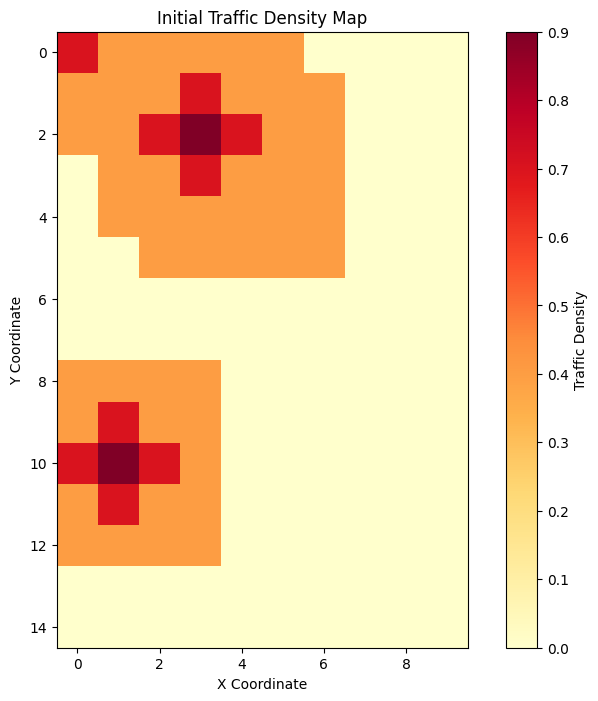


Initializing Uber network...

Starting simulation...
Starting simulation for 1000 time units
Scheduling next client arrival at time: 0.77
Client C3090 added to secondary queue
Attempting to match - Available drivers: 5

Starting Queue Matching Process:
Main Queue Size: 0
Secondary Queue Size: 1
Available Drivers: 5

Processing Secondary Queue:
Initial queue size: 1
Available drivers: 5
Match found - Client: C3090, Driver: D158, Score: 0.483
Client C3090 not found in any queue

        Match Created:
        - Time: 0.6931584774976349
        - Client: C3090 (Normal)
        - Driver: D158 (UberX)
        - Pickup Route: (3, 8) -> (2, 3)
        
Queue processing complete - Matches made: 1
Total matches made: 1

        Pickup Start Details:
        - Time: 0.6931584774976349
        - Client ID: C3090
        - Driver ID: D158
        - Distance: 6
        - Traffic Density: 0.40
        - Estimated Duration: 9.51
        - Expected End Time: 10.20
        

            Driver Arrival

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
from map import city_map, Location
from uber_network import uber_network
def run_simulation_test(
    grid_size=(10, 10),
    simulation_time=10,
    client_arrival_rate=0.6,  # Average 1 client every 10 time units
    driver_arrival_rate=0.05,  # Average 1 driver every 20 time units
    num_hotspots=3,
    pre_simulation_drivers=20,
    seed=42
):
    """
    Run a complete test of the Uber simulation system.
    
    Args:
        grid_size: Tuple of (width, height) for the city grid
        simulation_time: Total time to run the simulation
        client_arrival_rate: Rate at which new clients appear
        driver_arrival_rate: Rate at which new drivers appear
        num_hotspots: Number of high-traffic areas
        pre_simulation_drivers: Number of drivers to start with
        seed: Random seed for reproducibility
    """
    # Set random seeds
    random.seed(seed)
    np.random.seed(seed)
    
    # Create city map and visualize initial traffic
    print("Initializing city map...")
    city = city_map(grid_size, num_hotspots)
    
    # Visualize initial traffic conditions
    plt.figure(figsize=(10, 8))
    traffic_data = np.zeros(grid_size)
    for (x, y), density in city.get_all_traffic_data().items():
        traffic_data[x][y] = density
    
    plt.imshow(traffic_data.T, cmap='YlOrRd', interpolation='nearest')
    plt.colorbar(label='Traffic Density')
    plt.title('Initial Traffic Density Map')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
    
    # Initialize network
    print("\nInitializing Uber network...")
    network = uber_network(
        city_map=city,
        client_arrival_rate=client_arrival_rate,
        driver_arrival_rate=driver_arrival_rate,
        simulation_time=simulation_time,
        pre_simulation_driver=pre_simulation_drivers,
        seed=seed
    )
    
    # Run simulation
    print("\nStarting simulation...")
    network.run()
    
    # Get final statistics
    stats = network.get_statistics()
    
    # Print detailed statistics
    print("\nDetailed Statistics:")
    print("-" * 50)
    print(f"Total Simulation Time: {simulation_time}")
    print(f"Total Clients: {stats['total_clients']}")
    print(f"Total Matches: {stats['total_matches']}")
    print(f"Total Completed Rides: {stats['total_completed_rides']}")
    print(f"Total Cancellations: {stats['total_cancellations']}")
    
    if stats['total_completed_rides'] > 0:
        print(f"Average Ride Time: {stats['average_ride_time']:.2f}")
    
    if stats['total_matches'] > 0:
        print(f"Average Wait Time: {stats['average_wait_time']:.2f}")
    
    print(f"Completion Rate: {stats['completion_rate']*100:.2f}%")
    print(f"Cancellation Rate: {stats['cancellation_rate']*100:.2f}%")
    
    # Get final queue sizes
    queue_sizes = network.get_queue_sizes()
    print(f"\nFinal Queue States:")
    print(f"Main Queue Size: {queue_sizes['main_queue']}")
    print(f"Secondary Queue Size: {queue_sizes['secondary_queue']}")
    
    return network, stats

if __name__ == "__main__":
    # Run simulation with default parameters
    network, stats = run_simulation_test(
        grid_size=(10, 15),
        simulation_time=1000,
        client_arrival_rate=0.6,
        driver_arrival_rate=0.1,
        num_hotspots=4,
        pre_simulation_drivers=5,
        seed=42
    )

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
from map import city_map, Location
from uber_network import uber_network
# Test script
city = city_map(grid_size=(10, 10), num_hotspots=2)
network = uber_network(
    city_map=city,
    client_arrival_rate=0.1,
    driver_arrival_rate=0.1,
    simulation_time=1000
)

# Get initial traffic at a test point
test_point = (5, 5)
initial_traffic = city.get_traffic_density(test_point)
print(f"Initial traffic at {test_point}: {initial_traffic:.3f}")

# Run simulation
network.run()

# Check final traffic
final_traffic = city.get_traffic_density(test_point)
print(f"Final traffic at {test_point}: {final_traffic:.3f}")

Initial traffic at (5, 5): 0.400
Starting simulation for 1000 time units

            Driver Arrival:
            - Time: 1.4936359277815592
            - Driver ID: D113
            - Type: UberLux
            - Location: (9, 6)
            - Active Drivers: 21
            

        Shift Scheduled:
        - Driver: D113
        - Duration: 8.42 hours
        - End Time: 30327.2545347211
        

Starting Queue Matching Process:
Main Queue Size: 0
Secondary Queue Size: 0
Available Drivers: 21
Total matches made: 0
Scheduling next client arrival at time: 9.78
Client C1664 added to secondary queue
Attempting to match - Available drivers: 21

Starting Queue Matching Process:
Main Queue Size: 0
Secondary Queue Size: 1
Available Drivers: 21

Processing Secondary Queue:
Initial queue size: 1
Available drivers: 21
Match found - Client: C1664, Driver: D105, Score: 1.141
Client C1664 not found in any queue

        Match Created:
        - Time: 1.6291961900118517
        - Client: C1664 (Pa

In [1]:
from map import city_map
from uber_network import uber_network
from Uber_Confidence_Interval import UberConfidenceIntervalAnalyzer
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Dict, List, Any

class SimulationRunner:
    def __init__(self, 
                 num_runs: int = 30,
                 grid_size: tuple = (20, 20),
                 simulation_time: int = 1000,
                 client_arrival_rate: float = 0.1,
                 driver_arrival_rate: float = 0.05,
                 pre_simulation_drivers: int = 20,
                 confidence_level: float = 0.95):
        """
        Initialize the simulation runner.
        
        Args:
            num_runs: Number of simulation runs
            grid_size: Size of the city grid (width, height)
            simulation_time: Duration of each simulation
            client_arrival_rate: Average rate of client arrivals
            driver_arrival_rate: Average rate of driver arrivals
            pre_simulation_drivers: Number of drivers at start
            confidence_level: Confidence level for intervals
        """
        self.num_runs = num_runs
        self.grid_size = grid_size
        self.simulation_time = simulation_time
        self.client_arrival_rate = client_arrival_rate
        self.driver_arrival_rate = driver_arrival_rate
        self.pre_simulation_drivers = pre_simulation_drivers
        self.results: List[Dict[str, Any]] = []
        self.analyzer = UberConfidenceIntervalAnalyzer(confidence_level)
        
        # For storing time series data
        self.time_series_data = {
            'queue_sizes': [],
            'active_drivers': [],
            'completion_rates': []
        }

    def run_simulations(self, base_seed: int = 42):
        """
        Run multiple simulations with different random seeds.
        
        Args:
            base_seed: Base random seed to generate different seeds for each run
        """
        print(f"\nStarting {self.num_runs} simulation runs...")
        total_start_time = time.time()
        
        for run in range(self.num_runs):
            # Generate unique seed for this run
            run_seed = base_seed + run
            print(f"\nRun {run + 1}/{self.num_runs}")
            print(f"Using seed: {run_seed}")
            
            # Run single simulation with timing
            start_time = time.time()
            result = self._run_single_simulation(run_seed)
            end_time = time.time()
            
            # Store results
            self.results.append(result)
            self.analyzer.add_simulation_run(result)
            
            # Print progress
            run_duration = end_time - start_time
            print(f"Run completed in {run_duration:.2f} seconds")
            print(f"Preliminary metrics:")
            print(f"- Completed rides: {result['total_completed_rides']}")
            print(f"- Completion rate: {result['completion_rate']*100:.2f}%")
            print(f"- Average wait time: {result.get('average_wait_time', 0):.2f}")
        
        total_duration = time.time() - total_start_time
        print(f"\nAll runs completed in {total_duration:.2f} seconds")
        
        # Analyze results
        self._analyze_results()

    def _run_single_simulation(self, seed: int) -> Dict[str, Any]:
        """
        Run a single simulation with the given seed.
        
        Args:
            seed: Random seed for this run
            
        Returns:
            dict: Simulation results
        """
        # Set random seeds
        random.seed(seed)
        np.random.seed(seed)
        
        # Create city map and network
        city = city_map(self.grid_size)
        network = uber_network(
            city_map=city,
            client_arrival_rate=self.client_arrival_rate,
            driver_arrival_rate=self.driver_arrival_rate,
            simulation_time=self.simulation_time,
            pre_simulation_driver=self.pre_simulation_drivers,
            seed=seed
        )
        
        # Store initial state for time series
        self._record_time_series(network, 0)
        
        # Run simulation
        network.run()
        
        # Store final time series data
        self._record_time_series(network, self.simulation_time)
        
        return network.get_statistics()

    def _record_time_series(self, network: uber_network, time: float):
        """Record time series data at given simulation time"""
        queue_sizes = network.get_queue_sizes()
        self.time_series_data['queue_sizes'].append({
            'time': time,
            'main_queue': queue_sizes['main_queue'],
            'secondary_queue': queue_sizes['secondary_queue']
        })
        
        self.time_series_data['active_drivers'].append({
            'time': time,
            'count': len(network.available_drivers)
        })
        
        if hasattr(network, 'stats'):
            completion_rate = (network.stats.get('total_completed_rides', 0) / 
                             network.stats.get('total_clients', 1))
            self.time_series_data['completion_rates'].append({
                'time': time,
                'rate': completion_rate
            })

    def _analyze_results(self):
        """Analyze results and generate visualizations"""
        # Get confidence intervals
        analysis_results = self.analyzer.analyze_results()
        
        # Print analysis
        print("\nFinal Analysis:")
        self.analyzer.print_analysis(analysis_results)
        
        # Generate visualizations
        self._plot_results()

    def _plot_results(self):
        """Generate visualization plots for the results"""
        plt.style.use('seaborn')
        
        # Completion Rate Distribution
        plt.figure(figsize=(10, 6))
        completion_rates = [result['completion_rate'] for result in self.results]
        plt.hist(completion_rates, bins=15, alpha=0.7)
        plt.title('Distribution of Completion Rates Across Runs')
        plt.xlabel('Completion Rate')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

        # Wait Times Box Plot
        plt.figure(figsize=(10, 6))
        wait_times = [result.get('wait_times', []) for result in self.results]
        plt.boxplot(wait_times)
        plt.title('Distribution of Wait Times Across Runs')
        plt.ylabel('Wait Time')
        plt.grid(True)
        plt.show()

        # Time Series Plot
        plt.figure(figsize=(12, 6))
        times = [data['time'] for data in self.time_series_data['queue_sizes']]
        main_queue = [data['main_queue'] for data in self.time_series_data['queue_sizes']]
        sec_queue = [data['secondary_queue'] for data in self.time_series_data['queue_sizes']]
        
        plt.plot(times, main_queue, label='Main Queue')
        plt.plot(times, sec_queue, label='Secondary Queue')
        plt.title('Queue Sizes Over Time')
        plt.xlabel('Simulation Time')
        plt.ylabel('Queue Size')
        plt.legend()
        plt.grid(True)
        plt.show()

def run_experiment(
    num_runs: int = 30,
    grid_size: tuple = (20, 20),
    simulation_time: int = 1000,
    client_arrival_rate: float = 0.1,
    driver_arrival_rate: float = 0.05,
    pre_simulation_drivers: int = 20,
    base_seed: int = 42
):
    """
    Convenience function to run a complete experiment.
    
    Args:
        num_runs: Number of simulation runs
        grid_size: Size of the city grid
        simulation_time: Duration of each simulation
        client_arrival_rate: Rate of client arrivals
        driver_arrival_rate: Rate of driver arrivals
        pre_simulation_drivers: Initial number of drivers
        base_seed: Base random seed
    """
    runner = SimulationRunner(
        num_runs=num_runs,
        grid_size=grid_size,
        simulation_time=simulation_time,
        client_arrival_rate=client_arrival_rate,
        driver_arrival_rate=driver_arrival_rate,
        pre_simulation_drivers=pre_simulation_drivers
    )
    
    runner.run_simulations(base_seed)

In [2]:
run_experiment(
    num_runs=30,
    grid_size=(30, 30),
    simulation_time=2000,
    client_arrival_rate=0.15,
    driver_arrival_rate=0.08,
    pre_simulation_drivers=30
)


Starting 30 simulation runs...

Run 1/30
Using seed: 42


ZeroDivisionError: division by zero